In [ ]:
import os
import json
import numpy as np
import seaborn as sns

from vae import Sampling, VAE

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets.fashion_mnist import load_data

import matplotlib.pyplot as plt

In [3]:
(_, _), (x_test, _) = load_data()

In [4]:
x_test = x_test.astype('float32') / 255.
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [8]:
latent_dim = 16 # 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x) #16
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [9]:
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')
vae.load_weights('./results/model_03/vae_weights')

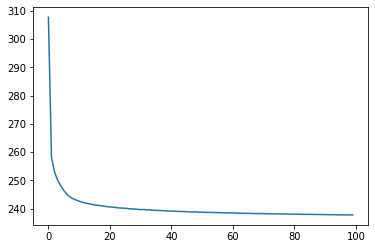

In [11]:
with open('./results/model_03/training_history.json', 'r') as f:
    history = json.load(f)
    
plt.plot(history['loss'])
# plt.plot(history['val_loss'])
plt.show()

In [12]:
z_mean, z_log_var, z = vae.encoder(x_test)

reconstruction = vae.decoder(z_mean)
reconstruction_errors = tf.reduce_mean(keras.losses.mean_squared_error(x_test, reconstruction), axis=(1, 2))

In [13]:
prioritization = np.argsort(reconstruction_errors)[::-1]

np.save('./tmp/vae.npy', prioritization)

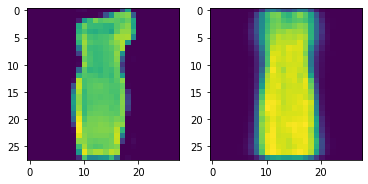

In [24]:
i = 1111

plt.subplot(121)
plt.imshow(x_test[i])
plt.subplot(122)
plt.imshow(reconstruction[i])
plt.show()

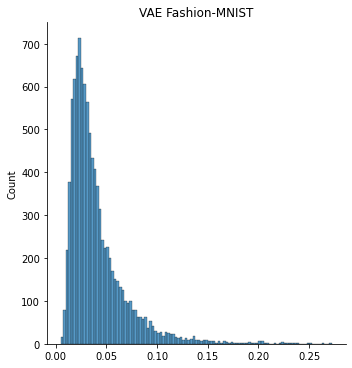

In [25]:
# plot the distribution of reconstruction errors

sns.displot(reconstruction_errors)
plt.title('VAE Fashion-MNIST')
# plt.savefig('./tmp/vae_fashion-mnist', bbox_inches='tight')
plt.show()